In [ ]:
!pip install ptitprince
!pip install --upgrade seaborn
!pip install --upgrade ptitprince

In [ ]:
import pandas as pd

# Read data
df = pd.read_excel("/content/Manual_AWS_GT_Black_White_For_Sharing.12.25.23(2).xlsx")

In [ ]:
manual_wc = "manual_word_count"
automatic_wc = "AWS_General_transcribe_word_count"
fake_id = "Fake_id"

In [ ]:
column_names = list(df.columns[:-2])
# column_names = list(df.columns)

column_names.remove("WER")
common_column_names = [name for name in column_names if name in [fake_id, 'race']]

In [ ]:
column_names

['Fake_id',
 'race',
 'manual_word_count',
 'AWS_General_transcribe_word_count',
 'Substitutions',
 'Insertions',
 'Deletions']

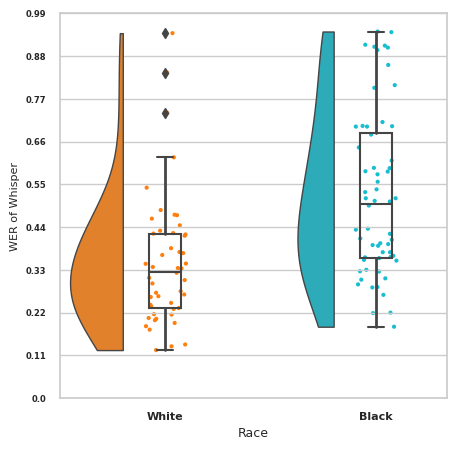

0.9516129032258065

In [ ]:
n = 80
def aggregate_rows_within_paragraphs(dataframe, min_words):
    # Prepare an empty list to hold aggregated data
    aggregated_data = []
    # Initialize a dictionary to temporarily hold sums of the current aggregation
    temp_sum = {col: 0 for col in column_names if col not in common_column_names}
    temp_sum[fake_id] = dataframe.iloc[0][fake_id]
    temp_sum['race'] = dataframe.iloc[0]['race']


    for _, row in dataframe.iterrows():
        if row[fake_id] != temp_sum[fake_id] or temp_sum[automatic_wc] >= min_words:
            # If the paragraph changes or the word count exceeds the minimum, reset the aggregation
            if temp_sum[automatic_wc] > 0:  # Avoid appending empty initial aggregation
                try:
                  temp_sum["WER"] = min(10, (temp_sum["Substitutions"] + temp_sum["Insertions"] + temp_sum["Deletions"]) / max(0, temp_sum[manual_wc]))
                except:
                  temp_sum["WER"] = 1

                aggregated_data.append(temp_sum)
            temp_sum = {col: 0 for col in column_names if col not in common_column_names}
            temp_sum[fake_id] = row[fake_id]
            temp_sum['race'] = row['race']

        # Aggregate current row
        for col in dataframe.columns:
            if col in common_column_names:
                continue  # Skip paragraph_id for aggregation
            temp_sum[col] += row[col]

    # Append the last aggregation if it's not empty
    if temp_sum[automatic_wc] > 0:

        temp_sum["WER"] = min(10, (temp_sum["Substitutions"] + temp_sum["Insertions"] + temp_sum["Deletions"]) / max(0, temp_sum[manual_wc]))
        aggregated_data.append(temp_sum)

    # Convert list of dicts to DataFrame
    return pd.DataFrame(aggregated_data)

# Aggregate the DataFrame
aggregated_df = aggregate_rows_within_paragraphs(df[column_names], n)
aggregated_df.race = aggregated_df.race.str.capitalize()
aggregated_df = aggregated_df.loc[aggregated_df["WER"] < 1]

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import ptitprince as pt

sns.set(style="whitegrid", font_scale=2)
# Define the columns for the plot
dx = aggregated_df["race"]  # Race column
dy = aggregated_df["WER"]   # Word Error Rate column
ort = "v"    # Orientation of the plot
pal = palette = ["#ff7f0e", "#17becf"] # Color palette
sigma = 0.6 # Bandwidth for the KDE in the RainCloud plot

size = 12
plt.rc('axes', labelsize=size)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)

# Create the figure
f, ax = plt.subplots(figsize=(5, 5))

# Create the RainCloud plot
ax = pt.RainCloud(x=dx, y=dy, data=aggregated_df, palette=pal, bw=sigma,
                  width_viol=.5, ax=ax, orient=ort, cut=0, dodge = False, alpha=1, rain_alpha=1)

yticks = np.linspace(0, 0.999, 10)
ax.set_yticks(yticks)
plt.xticks(fontsize=8, weight="bold")
# ax.set_yticklabels(['{:.1f}'.format(y) for y in yticks])
ax.set_yticklabels(np.floor(yticks * 100) / 100, fontsize=6, weight="bold")
ax.set_ylabel("WER of Whisper", fontsize=8)
ax.set_xlabel("Race", fontsize=9)

plt.show()
aggregated_df["WER"].max()

In [ ]:
f.savefig("whisper_wer.svg", bbox_inches='tight')

In [ ]:
aggregated_df["model"] = "AWS Medical"

In [ ]:
aggregated_df_AWS_medical = aggregated_df.copy()

In [ ]:
whisper = aggregated_df.copy()

In [ ]:
aggregated_df_AWS_general = aggregated_df.copy()

In [ ]:
all_models_wer = pd.concat([aggregated_df_AWS_general[["WER", "model"]], aggregated_df_AWS_medical[["WER", "model"]],
                            whisper[["WER", "model"]]], axis=0)


In [ ]:
all_models_wer = all_models_wer.replace("AWS Medical", "AWS Medical Transcribe")

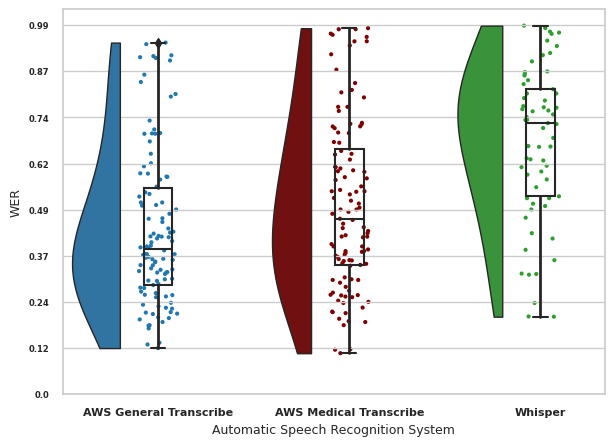

Text(0.5, 23.0, 'Race')

In [ ]:
sns.set(style="whitegrid", font_scale=2)
# Define the columns for the plot
dx = all_models_wer["model"]  # Race column
dy = all_models_wer["WER"]   # Word Error Rate column
ort = "v"    # Orientation of the plot
pal = "Set2" # Color palette
sigma = 0.6 # Bandwidth for the KDE in the RainCloud plot

size = 12
plt.rc('axes', labelsize=size)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)

# Create the figure
f, ax = plt.subplots(figsize=(7, 5))

palette = ["#1f77b4", "#800000", "#2ca02c"]
# Create the RainCloud plot
ax = pt.RainCloud(x=dx, y=dy, data=all_models_wer, palette=palette, bw=sigma,
                  width_viol=.5, ax=ax, orient=ort, cut=0, dodge = False, alpha=1, rain_alpha=1)

plt.xticks(fontsize=8, weight="bold")
yticks = np.linspace(0, 0.999, 9)
ax.set_yticks(yticks)
ax.set_yticklabels(np.floor(yticks * 100) / 100, fontsize=6, weight="bold")
ax.set_ylabel("WER", fontsize=9)
ax.set_xlabel("Automatic Speech Recognition System", fontsize=9)

plt.show()

# ax.set_yticklabels(['{:.1f}'.format(y) for y in yticks])
ax.set_xlabel("Race", fontsize=10)


In [ ]:
f.savefig("all_models.jpg", bbox_inches='tight', dpi=600)

In [ ]:
all_models_wer.to_csv("wers_final.csv")

# Statistical Analysis

In [ ]:
import pandas as pd
from scipy.stats import brunnermunzel, mannwhitneyu, ttest_ind

black_wer = aggregated_df[aggregated_df['race'] == 'Black']['WER']
white_wer = aggregated_df[aggregated_df['race'] == 'White']['WER']

# Performing the Brunner-Munzel test
stat, p_value = brunnermunzel(black_wer, white_wer)

# stat, p_value = mannwhitneyu(black_wer, white_wer, alternative='two-sided')

stat, p_value = ttest_ind(black_wer, white_wer, equal_var=False)

print(f"Brunner-Munzel Test Statistic: {stat}")
print(f"P-value: {p_value}")